In [41]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [43]:
train_dir ='dataTest/Train'
validation_dir = 'dataTest/Valid'

In [44]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 5400 files belonging to 2 classes.
Found 1400 files belonging to 2 classes.


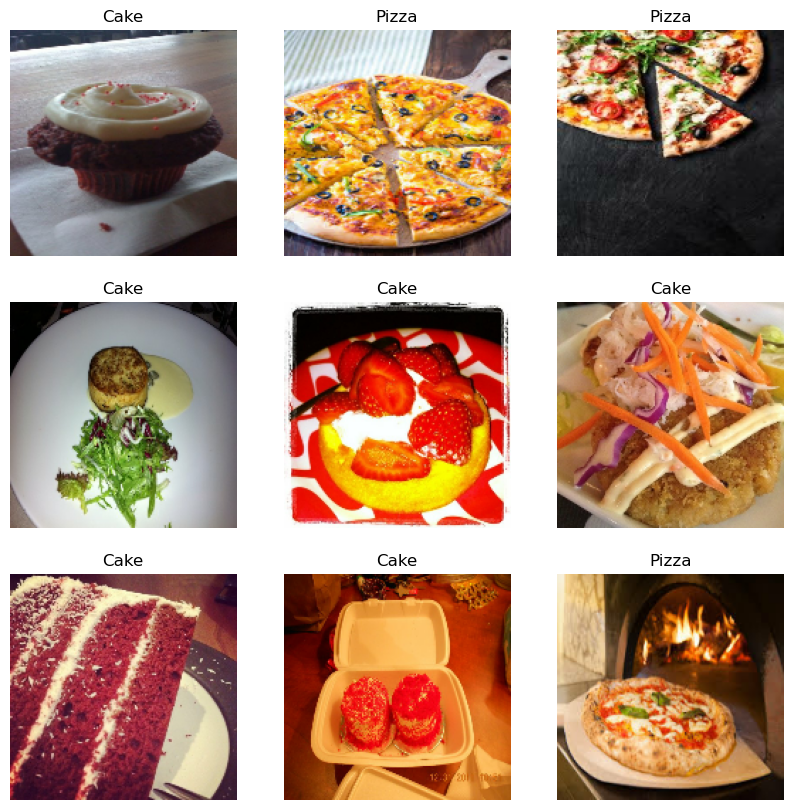

In [45]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
train_generator = train_data_generator.flow_from_directory(
                train_dir, target_size=HYP['img_size'],
                shuffle=True, seed=HYP['seed'],
                class_mode='categorical', 
                batch_size=HYP['batch_size'],
                subset="training")

validation_generator = val_data_generator.flow_from_directory(
                    train_dir, target_size=HYP['img_size'],
                    shuffle=False, seed=HYP['seed'],
                    class_mode='categorical',
                    batch_size=HYP['batch_size'],
                    subset="validation")

Found 4590 images belonging to 2 classes.
Found 810 images belonging to 2 classes.


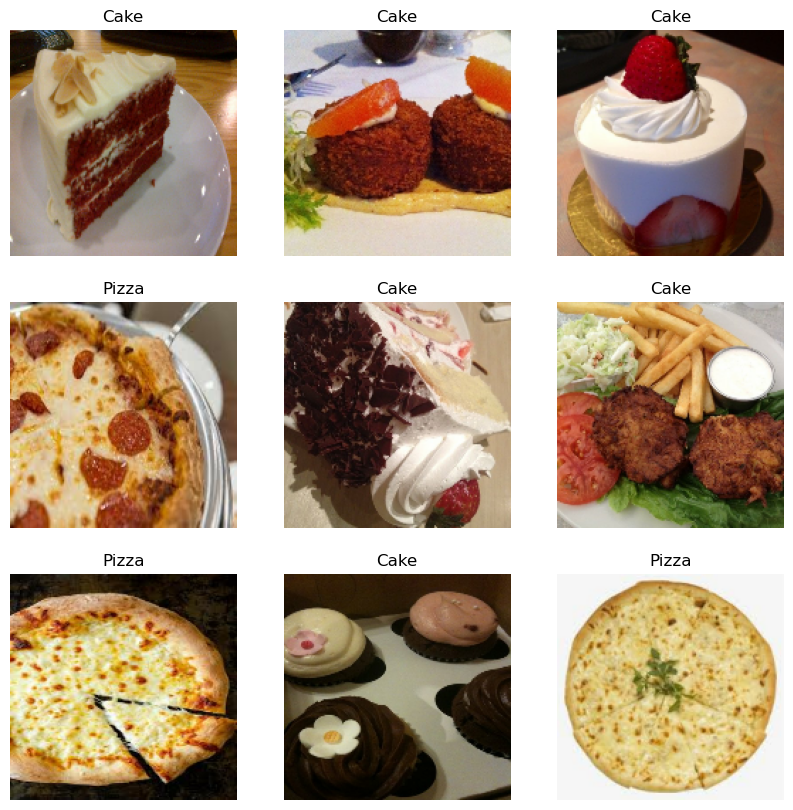

In [46]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [47]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [48]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 36
Number of test batches: 8


In [49]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [50]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

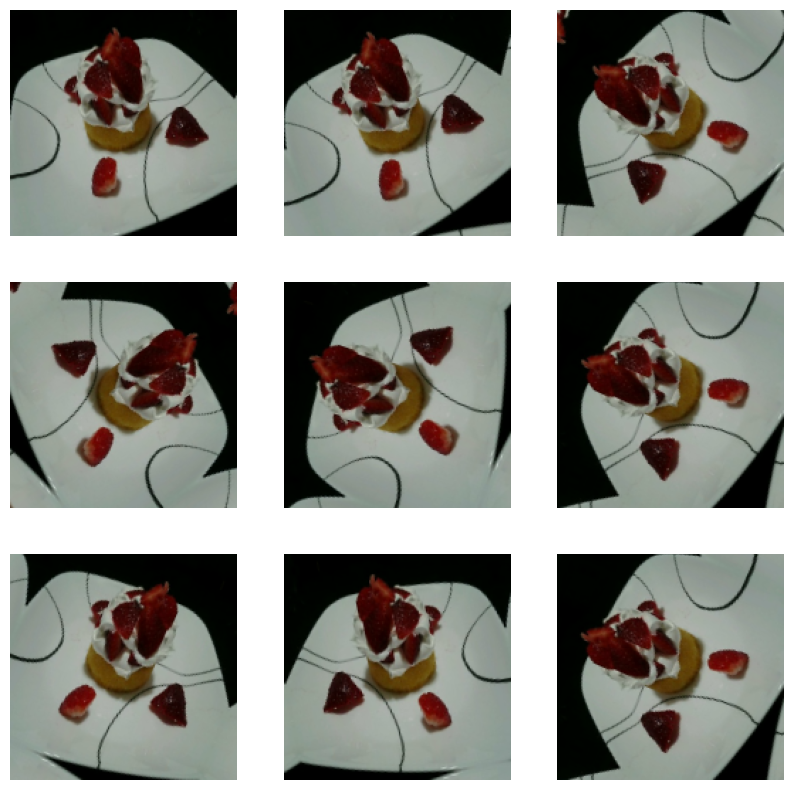

In [51]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [52]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [53]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [54]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [55]:
base_model.trainable = False

In [56]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [57]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [58]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [59]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [60]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [62]:
len(model.trainable_variables)

2

In [63]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

36/36 [==============================] - 11s 256ms/step - loss: 1.0511 - accuracy: 0.4073
initial loss: 1.05
initial accuracy: 0.41


In [64]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
169/169 [==============================] - 63s 351ms/step - loss: 0.5755 - accuracy: 0.7159 - val_loss: 0.3153 - val_accuracy: 0.8846
Epoch 2/10
169/169 [==============================] - 55s 325ms/step - loss: 0.3113 - accuracy: 0.8602 - val_loss: 0.1975 - val_accuracy: 0.9467
Epoch 3/10
169/169 [==============================] - 54s 321ms/step - loss: 0.2188 - accuracy: 0.9157 - val_loss: 0.1400 - val_accuracy: 0.9615
Epoch 4/10
169/169 [==============================] - 54s 320ms/step - loss: 0.1680 - accuracy: 0.9378 - val_loss: 0.1140 - val_accuracy: 0.9685
Epoch 5/10
169/169 [==============================] - 55s 325ms/step - loss: 0.1439 - accuracy: 0.9494 - val_loss: 0.1009 - val_accuracy: 0.9712
Epoch 6/10
169/169 [==============================] - 55s 327ms/step - loss: 0.1249 - accuracy: 0.9541 - val_loss: 0.0858 - val_accuracy: 0.9738
Epoch 7/10
169/169 [==============================] - 54s 321ms/step - loss: 0.1090 - accuracy: 0.9648 - val_loss: 0.0756 - val_ac

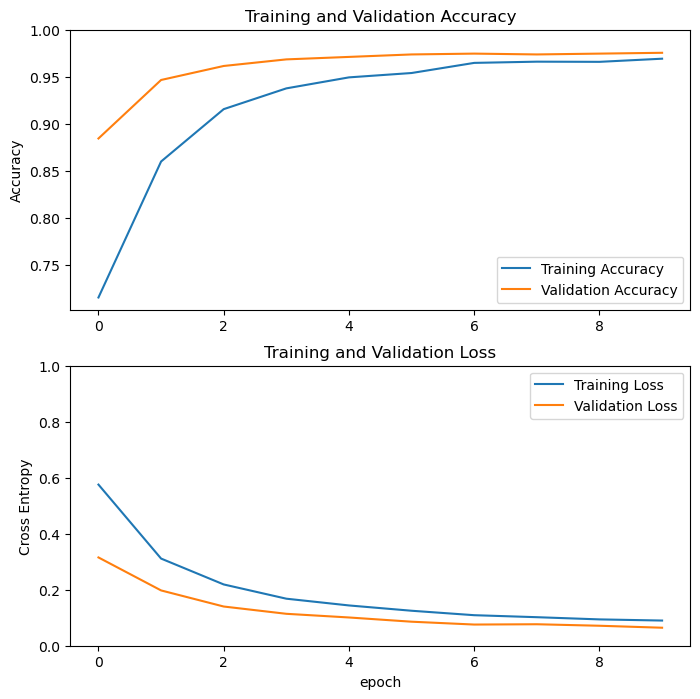

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [66]:
base_model.trainable = True

In [67]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [68]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [70]:
len(model.trainable_variables)

56

In [71]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
169/169 [==============================] - 83s 459ms/step - loss: 0.0560 - accuracy: 0.9809 - val_loss: 0.0402 - val_accuracy: 0.9834
Epoch 11/20
169/169 [==============================] - 75s 445ms/step - loss: 0.0349 - accuracy: 0.9891 - val_loss: 0.0445 - val_accuracy: 0.9825
Epoch 12/20
169/169 [==============================] - 75s 444ms/step - loss: 0.0284 - accuracy: 0.9902 - val_loss: 0.0341 - val_accuracy: 0.9904
Epoch 13/20
169/169 [==============================] - 76s 447ms/step - loss: 0.0229 - accuracy: 0.9911 - val_loss: 0.0358 - val_accuracy: 0.9860
Epoch 14/20
169/169 [==============================] - 76s 449ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 0.0276 - val_accuracy: 0.9930
Epoch 15/20
169/169 [==============================] - 75s 444ms/step - loss: 0.0171 - accuracy: 0.9943 - val_loss: 0.0367 - val_accuracy: 0.9904
Epoch 16/20
169/169 [==============================] - 75s 442ms/step - loss: 0.0143 - accuracy: 0.9946 - val_loss: 0.0349 -

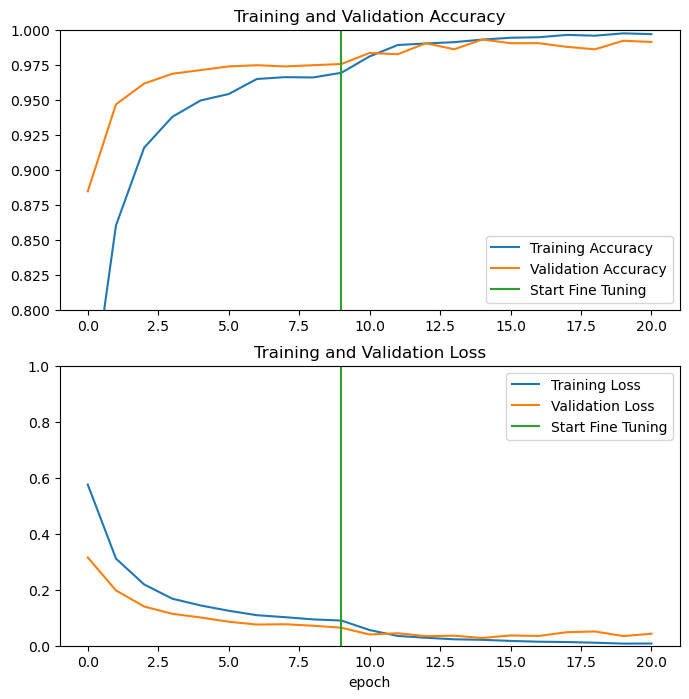

In [72]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [73]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 2s 259ms/step - loss: 0.0222 - accuracy: 0.9922
Test accuracy : 0.9921875


Predictions:
 [0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0]
Labels:
 [0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0]


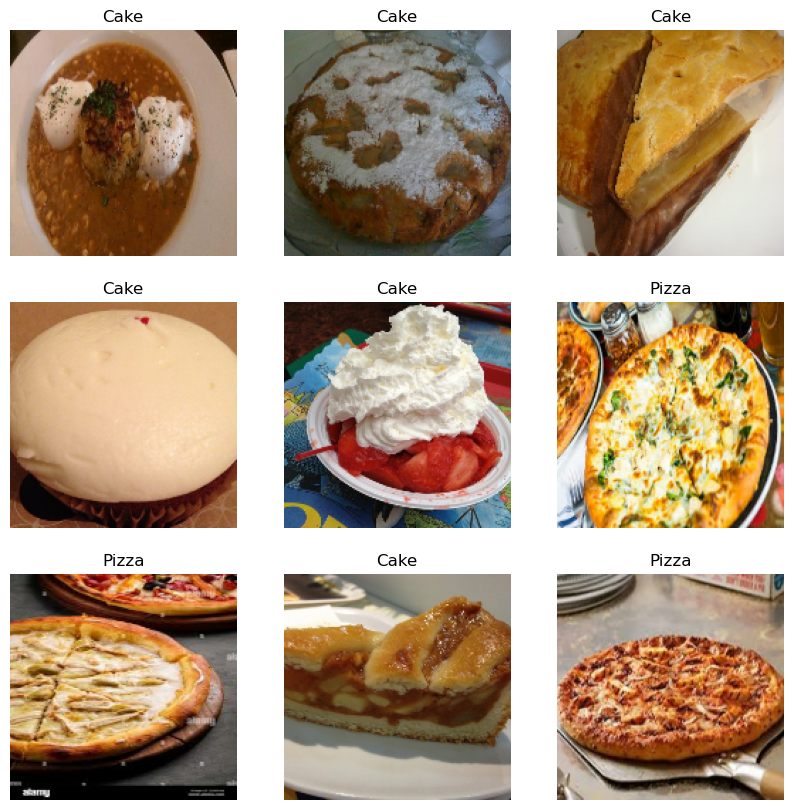

In [74]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")